# Visual Document Classifier v2

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['JSL_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [2]:
import sys

sys.path.append("../../spark-ocr/python/")

In [3]:
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
#%pip install ../../python/dist/spark-ocr-3.9.0+spark30.tar.gz

In [5]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [6]:
from sparkocr import start
from pyspark import SparkConf

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.11.0



## Load test images

In [7]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/visualdoc/0000157402.tif')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/home/alexan...|2020-06-11 10:25:56| 91164|[49 49 2A 00 46 6...|
+--------------------+-------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/visualdoc/0000157402.tif
    Resolution: 72 dpi
    Width: 762 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


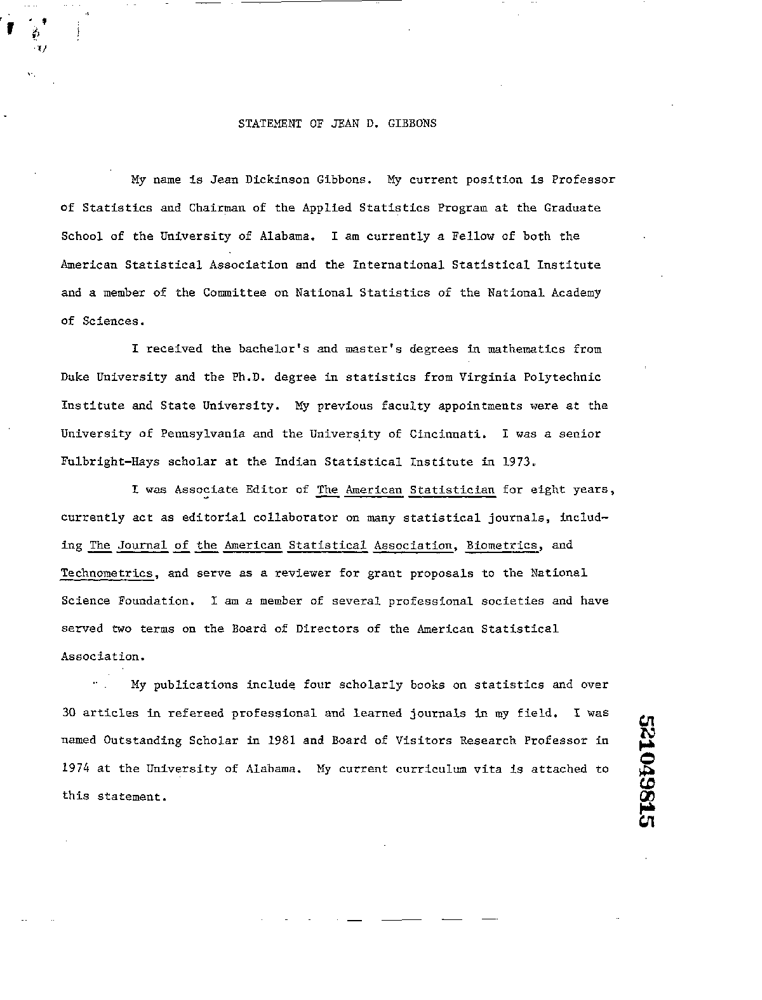

In [8]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [9]:
vocab_file = open("vocabulary.txt", "r")
vocab = {}
for line in vocab_file:
    tmp = line.strip().split(',')
    vocab[tmp[0]] = tmp[1]
vocab_file.close()

binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_class = VisualDocumentClassifierV2() \
    .loadONNXModel("/model.onnx", spark) \
    .setInputCols(["token", "image"]) \
    .setOutputCol("label")
doc_class.setVocabulary(vocab)


# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_class
])

## Call pipeline

In [10]:
results = pipeline.transform(bin_df).cache()

## Show results

In [15]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.select("label") \
    .show(truncate=False)
            

+-------------+
|label        |
+-------------+
|advertisement|
+-------------+

